<h1><center>Physique numérique (PHY-3500) - TP3</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [2]:
from typing import Callable

import numpy as np
from numba import njit
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from astropy import constants as cte


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Mécanique céleste - la Terre

A) *Utilisez la méthode de Verlet pour calculer l’orbite de la Terre autour du soleil, considérant que le mouvement est décrit par*
$$\frac{d^2\boldsymbol{r}}{dt^2}=-\frac{GM}{r^3}\boldsymbol{r}$$

*et sachant que la distance du périhélie est de $1.4710\cdot 10^{11}$ m et que la vitesse tangentielle à cette position est de $3.0287\cdot 104$ m/s (utilisez le module astropy pour les autres constantes nécessaires). Utilisez un incrément temporel $h = 1$ heure. Représentez graphiquement plusieurs orbites, qui devraient appaître légèrement non-circulaires.*

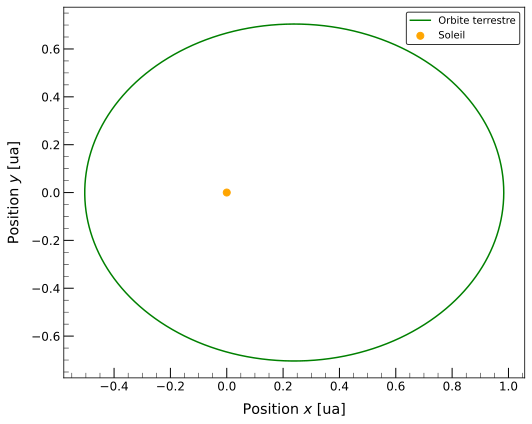

In [3]:
G = cte.G.value
M_sun = cte.M_sun.value

# Conditions initiales
r_peri = 1.4710e11
v_peri = 3.0287e4

# Temps: 1 an avec un pas de 1 heure (3600 s)
# On utilise dt = 3600 s puisqu'on utilise les unités SI MKS
dt = 3600
N = 365 * 24

# Initialisation des vecteurs de position, de vitesse et d'accélération
r = np.empty((N, 2))
v = np.empty((N, 2))

# Conditions initiales : au périhélie, la Terre se déplace uniquement selon y
r[0] = np.asarray([r_peri, 0])
v[0] = np.asarray([0, v_peri])

for i in range(N - 1):
    # Calcul de l'accélération
    r_norm = np.linalg.norm(r[i])
    a = -G * M_sun * r[i] / r_norm**3

    # Équation de Verlet pour la position
    if i == 0:
        # Premier pas spécial pour la vitesse à t + 1/2 dt
        v_half = v[i] + 0.5 * dt * a
    else:
        v_half = v[i] + dt * a

    r[i + 1] = r[i] + dt * v_half

    # Nouveau calcul de l'accélération pour le pas suivant
    r_norm_next = np.linalg.norm(r[i + 1])
    a_next = -G * M_sun * r[i + 1] / r_norm_next**3

    # Vitesse à t + dt
    v[i + 1] = v_half + 0.5 * dt * a_next

# Convertir les m en untité astronomique pour le graphique
r_au = r / cte.au

# Tracer l'orbite de la Terre autour du Soleil
plt.figure(figsize=(7.5, 6))
plt.plot(r_au[:, 0], r_au[:, 1], "g", label="Orbite terrestre")
plt.scatter(0, 0, color="orange", s=50, label="Soleil")
plt.xlabel("Position $x$ [ua]")
plt.ylabel("Position $y$ [ua]")
plt.legend()
plt.show()

B) *Modifier votre programme pour qu’il calcule aussi l’énergie potentielle $−\frac{GMm}{r}$ et cinétique $\frac{mv}{2}$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantités. Rapportez ces valeurs en fonction du temps dans un graphique et commentez.*

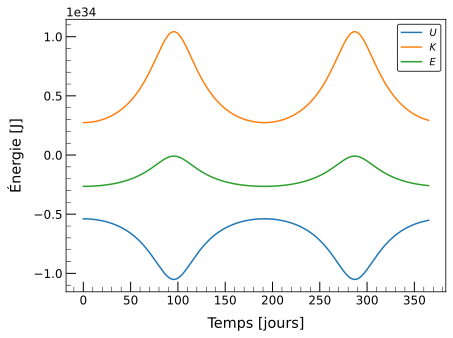

In [4]:
M_earth = cte.M_earth.value

# Énergie potentielle: U = -G * M_sun * m / r
r_norm = np.linalg.norm(r, axis=1)
U = -G * M_sun * M_earth / r_norm

# Énergie cinétique: K = 1/2 * m * v^2
v_norm = np.linalg.norm(v, axis=1)
K = 0.5 * M_earth * v_norm**2

E = U + K
time = np.linspace(0, N, E.size) / 24

# Tracer les énergies en fonction du temps pour l'orbite de la Terre
plt.plot(time, U, label="$U$")
plt.plot(time, K, label="$K$")
plt.plot(time, E, label="$E$")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie [J]")
plt.legend()
plt.show()

Le graphique montre l'évolution de l'énergie potentielle $U$, de l'énergie cinétique $K$, et de l'énergie totale $E$ de la Terre autour du Soleil en fonction du temps, mesuré en jours, sur une période d'un an. Comme attendu pour un système conservatif, L'énergie potentielle varie de manière inversée par rapport à l'énergie cinétique : lorsque la Terre s'approche du Soleil (diminution de la distance $r$), l'énergie potentielle devient plus négative tandis que l'énergie cinétique augmente, et vice versa. Toutefois, l'énergie totale, sensée demeurer constante par conservation de l'énergie dans le système Terre-Soleil, montre des fluctuations tout au long de l'orbite. Ces oscillations indiquent des variations individuelles de l'énergie cinétique et potentielle. Ces variations peuvent être causées par un manque de précision dans la résolution de l'équation différentielle de l'acclélération.

C) *Utilisez maintenant la méthode d’Euler, RK2 et RK4 pour calculer l’orbite de la Terre et l’énergie totale en fonction du temps, que vous rapportez sur le même graphique que l’énergie totale en fonction du temps calculée par la méthode de Verlet. Votre graphique devrait montrer le caractère symplectique de la méthode de Verlet vs Euler/RK2/RK4.*

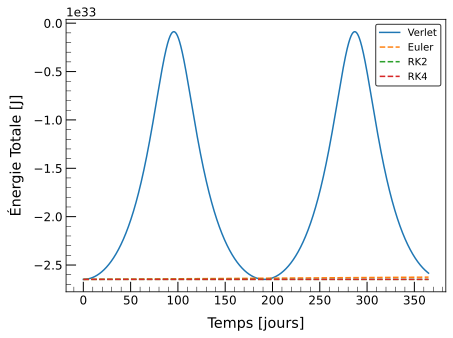

In [5]:
def acceleration(r: NDArray) -> NDArray:
    """Calcule l'accélération gravitationnelle à une position donnée.

    Paramètre
    ---------
    r
        Vecteur de la position.

    Retourne
    --------
    a
        Vecteur de l'acclélération.

    """
    a = -G * M_sun * r / np.linalg.norm(r)**3
    return a


def euler(r: NDArray, v: NDArray, dt: int) -> tuple[NDArray]:
    """Effectue un pas de temps en utilisant la méthode d'Euler.

    Paramètres
    ----------
    r
        Vecteur de la postion.
    v
        Vecteur de la vitesse.
    dt
        Incrément de temps.

    Retourne
    --------
    r_next
        Vecteur de la position après l'incrément de temps.
    v_next
        Vecteur de la vitesse après l'incrément de temps.

    """
    a = acceleration(r)
    r_next = r + v * dt
    v_next = v + a * dt
    return r_next, v_next


def rk(r: NDArray, v: NDArray, dt: int, order: int = 2) -> tuple[NDArray]:
    """Effectue un pas de temps en utilisant la méthode de Runge-Kutta.

    Paramètres
    ----------
    r
        Coordonnées de la position en 2D.
    v
        Vecteur de la vitesse.
    dt
        Pas de temps.
    order
        Ordre de la méthode de Runge-Kutta.

    Retourne
    --------
    r_next
        Vecteur de la position après l'incrément de temps.
    v_next
        Vecteur de la vitesse après l'incrément de temps.

    Soulève
    -------
    ValueError
        Si l'ordre spécifié est ni 2 ni 4.

    """
    # Coefficients de Runge-Kutta d'ordre 2 et 4
    if order == 2:
        a = np.asarray((0, 1))
        b = np.asarray((0.5, 0.5))
    elif order == 4:
        a = np.asarray((0, 0.5, 0.5, 1))
        b = np.asarray((1/6, 1/3, 1/3, 1/6))
    else:
        raise ValueError("Seul les ordres 2 et 4 sont supportés")

    # Initialisation des coefficients k de la vitesse et de la position
    kr = np.empty((order, 2))
    kv = np.empty_like(kr)
    kr[0] = v
    kv[0] = acceleration(r)

    # Méthode de Runge-Kutta
    for n, ak in enumerate(a):
        kr[n] = v + dt * ak * kv[n - 1]
        kv[n] = acceleration(r + dt * ak * kr[n - 1])

    r_next = r + dt * (b @ kr)
    v_next = v + dt * (b @ kv)
    return r_next, v_next


# Fonction pour calculer l'orbite et l'énergie totale en utilisant une méthode donnée
def energie(methode, r0: NDArray, v: NDArray, N: int, dt: int, **kwargs):
    """Calcule de l'énergie totale de la Terre avec une méthode donnée.

    Paramètres
    ----------
        methode
            Fonction à utiliser pour le calcul de l'énergie.
        r0
            Coordonnées de la position initiale en 2D.
        v0
            Vecteur de vitesse initiale.
        N
            Nombre de pas de temps.
        dt
            Incrément de temps.

    Retourne
    --------
        E
            Énergie totale de la Terre en tout point.

    """
    r = np.empty((N, 2))
    v = np.empty((N, 2))
    r[0] = r0
    v[0] = v0

    # Calcul des orbites
    for i in range(N - 1):
        r[i + 1], v[i + 1] = methode(r[i], v[i], dt, **kwargs)

    # Calcul de l'énergie totale
    r_norm = np.linalg.norm(r, axis=1)
    v_norm = np.linalg.norm(v, axis=1)
    U = -G * M_sun * M_earth / r_norm
    K = 0.5 * M_earth * v_norm**2
    E = U + K
    return E


# Conditions initiales et méthodes
r0, v0 = r[0], v[0]

# Calcul des énergies pour chaque méthode
E_euler = energie(euler, r0, v0, N, dt)
E_rk2 = energie(rk, r0, v0, N, dt)
E_rk4 = energie(rk, r0, v0, N, dt, order=4)

# Tracé de l'énergie totale pour chaque méthode
plt.plot(time, E, label="Verlet")
plt.plot(time, E_euler, ls="--", label="Euler")
plt.plot(time, E_rk2, ls="--", label="RK2")
plt.plot(time, E_rk4, ls="--", label="RK4")
plt.xlabel("Temps [jours]")
plt.ylabel("Énergie Totale [J]")
plt.legend()
plt.show()

Le graphique compare l'énergie totale de la Terre autour du Soleil calculée par la méthode de Verlet et par la méthode de Runge-Kutta d'ordre 2 et 4 au cours d'une année, avec un pas de temps d'une heure. Physiquement, l'énergie totale du système devrait demeurer constante dans le temps, malgré les fluctuations de l'énergie potentielle et cinétique, en vertu de la loi de la conservation de l'énergie. Pourtant, le graphique montre que la méthode de Verlet produit des valeurs de $E$ significativement moins constantes qu'avec la méthode d'Euler et de Rounge-Kutta. Ces fluctuations importantes témoignent du caracètre symplectique de la méthode de Verlet. Les méthodes de Rounge-Kutta et d'Euler, en revanche, offrent une plus grande stabilité et une meilleure précision pour des calculs différentiels comme ceux-ci.

D) Utilisez maintenant la méthode de Bulirsch-Stoer pour calculer l’orbite de la Terre, avec une précision de 1 km par année (voir l’exemple 8.7 dans le Newman pour une implémentation, que vous pouvez réutiliser). Utilisez un intervalle $h$ de une semaine. Comparez avec la précision obtenue avec les autres méthodes.

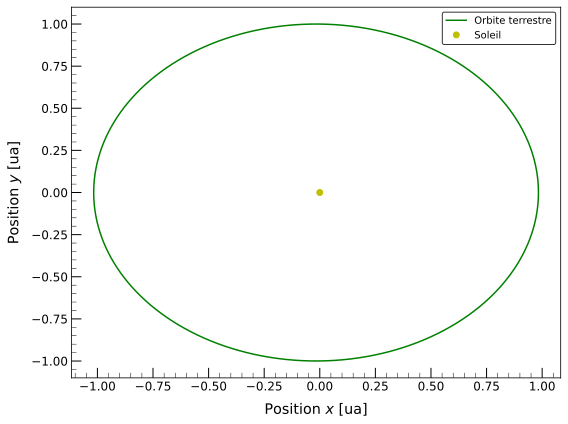

In [6]:
@njit(fastmath=True, nogil=True)
def bulirsch_stoer(
    y: NDArray,
    t: float,
    tf: float,
    dt: float,
    tol: float = 1e6,
    n_steps: int = 4,
) -> list[NDArray]:
    """Calcule l'orbite Terre-Soleil avec la méthode de Bulirsch-Stoer.

    Cette fonction exploite la compilation "Just-in-time" avec le décorateur
    "njit" pour compenser le temps de calcul important des boucles while pour
    des petites tolérances. Cependant, ce décorateur ne supporte pas directement
    les fonctions comme type de donnée. La sépratation des grandes étapes de
    calcul avec des fonctions a été conserver par soucis de clarté, mais elles
    ont été imbriquées au sein de la fonction principale pour demeurer compatible
    avec "njit".

    Paramètres
    ----------
    y
        Vecteur d'état initial.
    t
        Temps initial.
    tf
        Temps final.
    dt
        Pas de temps initial.
    tol
        Tolérance pour le contrôle d'erreur. Par défaut : 1e6.
    n_steps
        Nombre d'étapes pour l'extrapolation de Richardson.
        Par défaut : 4.

    Retourne
    --------
    solution
        Liste de vecteurs d'état représentant la trajectoire.

    """
    def acceleration(rv: NDArray) -> NDArray:
        """Calcul de l'accélération gravitationnelle d'un corps.

        Paramètre
        ---------
        rv
            Le vecteur d'état de la position et de la vitesse du corps.

        Retourne
        --------
        va
            Le vecteur d'état de la vitesse et de l'accélération
            du corps.

        """
        r, v = rv[:2], rv[2:]
        a = -r / np.linalg.norm(r)**3 * G * M_sun
        va = np.concatenate((v, a))
        return va

    def runge_kutta(func, y, h):
        a = np.asarray((0, 0.5, 0.5, 1))
        b = np.asarray((1/6, 1/3, 1/3, 1/6))
        k = np.empty((4, y.size))
        for n in range(4):
            k[n] = h * func(y + a[n] * k[n - 1])

        y2 = y + b @ k
        return y2

    def modified_midpoint(func: Callable, y: NDArray, h: float) -> NDArray:
        """Effectue un pas avec la méthode des demi-points modifiée.

        Paramètres
        ----------
        func
            La fonction à utiliser pour l'extrapolation.
        y
            Le vecteur d'état initial.
        h
            Le pas à utiliser pour l'extrapolation.

        Retourne
        --------
        y2
            Le vecteur d'état final.

        """
        y1 = y + 0.5 * h * func(y)
        y2 = y + h * func(y1)
        return y2

    solution = [y]
    while t < tf:
        # Tailles de pas décroissantes pour l'extrapolation
        H = dt / np.power(2, np.arange(1, n_steps))

        R = np.empty((H.size, y.size))
        R2 = modified_midpoint(acceleration, y, dt)
        for n, h in enumerate(H):
            R[n] = modified_midpoint(acceleration, y, h)

            # Extrapolation de Richardson
            y_new = R2 + (R2 - R[-1]) / (dt / h)**2
            error = np.linalg.norm(y_new - R2)
            if error < tol:
                break

        # Ajuster dynamiquement le pas de temps pour respecter la tolérance
        if error >= tol:
            dt *= 0.95 * tol / error
        else:
            y = y_new
            t += dt
            solution.append(y)
            if error < tol / 2:
                dt *= 0.95 * tol / error

    return solution


# Conditions initiales
y0 = np.concatenate((r0, v0))
tol = 1e5

# Convertir les temps en s pour la cohérance des unités
year = 365 * 24 * 3600
week = 604800

solution = bulirsch_stoer(y0, 0, year, week, tol, 2)
solution = np.asarray(solution)

# Convertir les m en untité astronomique pour le graphique
pos_au = solution[:, :2] / cte.au

plt.figure(figsize=(8, 6))
plt.plot(pos_au[:, 0], pos_au[:, 1], "g", label="Orbite terrestre")
plt.plot(0, 0, "yo", label="Soleil")
plt.xlabel("Position $x$ [ua]")
plt.ylabel("Position $y$ [ua]")
plt.legend()
plt.show()

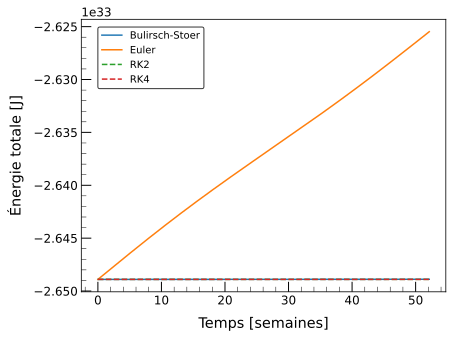

In [7]:
# Calcul de l'énergie totale
r_norm = np.linalg.norm(solution[:, :2], axis=1)
v_norm = np.linalg.norm(solution[:, 2:], axis=1)
U = -G * M_sun * M_earth / r_norm
K = 0.5 * M_earth * v_norm**2
E = U + K

time_week = np.linspace(0, 365 / 7, E.size)

# Tracé de l'énergie
# plt.figure(figsize=(8, 6))
# plt.plot(time_week, E, label="Bulirsch-Stoer")
# plt.plot(time_week, U, label="$U$ Bulirsch-Stoer")
# plt.plot(time_week, K, label="$K$ Bulirsch-Stoer")

plt.plot(time_week, E, label="Bulirsch-Stoer")
plt.plot(time / 7, E_euler, label="Euler")
plt.plot(time / 7, E_rk2, ls="--", label="RK2")
plt.plot(time / 7, E_rk4, ls="--", label="RK4")
plt.xlabel("Temps [semaines]")
plt.ylabel("Énergie totale [J]")
plt.legend(bbox_to_anchor=(0.35, 0.99))
# plt.legend()
plt.show()

# Mécanique céleste - Mars

In [9]:
import de421
from astropy.time import Time
from jplephem import Ephemeris


eph = Ephemeris(de421)

# Dates
lancement = Time("2020-07-30")
atterissage = Time("2021-02-18")

# un nombre de jours juliens est attendu par la routine, d’o`u le .jd
# position en km, vitesse en km par jour
position, velocity = eph.position_and_velocity("mars", lancement.jd)

E) *Utilisez Bulirsch-Stoer pour calculer la position de Mars 203 jours plus tard, soit le 18 février 2021 (jour de l’atterrissage). Ne lésinez pas sur la précision, ca coûte cher un astromobile. Notez que les calculs seront effectués en trois dimensions. Comparez votre position calculée à la valeur de l’éphéméride, soit eph.position("mars", atterissage.jd). Commentez, notamment sur vos limites et celles de la méthode utilisée.*

F) *Quelle méthode numérique la NASA utilise-t-elle pour envoyer des sondes vers Mars ?*
<br><br>

La NASA utilise principalement le transfert de Hohmann, une méthode efficace pour transférer un vaisseau spatial d'une orbite circulaire à une autre avec un seul changement de vitesse (impulsion) au point le plus bas et le plus haut de l'orbite de transfert. Pour les missions vers Mars, cela signifie calculer l'orbite de transfert qui mène efficacement de l'orbite terrestre à l'orbite martienne avec un minimum de propulsion.

Cette méthode est-elle en cause dans la perte du Mars Climate Orbiter en 1999 ? Si non, quelle a été la cause de cette perte ?
<br><br>
Non, la perte du Mars Climate Orbiter n'est pas due directement à la méthode numérique utilisée pour calculer sa trajectoire, mais plutôt à une erreur de communication entre les équipes. Un groupe utilisait le système métrique, tandis que l'autre utilisait le système impérial. Cette incohérence dans les unités de mesure a conduit à une erreur dans la trajectoire de la sonde, la faisant entrer dans l'atmosphère martienne à une altitude plus basse que prévu, ce qui a résulté en sa destruction.

# L’équation de Schrödinger et la méthode spectrale

H) Ecrivez un programme pour calculer les valeurs des coefficients $\beta_k$, qui peuvent de façon pratique être séparés en composantes réelles et imaginaires ($\beta_k = \alpha_k + i\eta_k$). Divisez la boÎte en N = 1000 tranches et créez deux conteneurs pour les parties rélles et imaginaires de $\psi(x_n, 0)$ à chaque point de la grille. Effectuez une transformée en sinus pour chaque conteneur séparément, i.e. calculez les valeurs de $\alpha_k$ et $\beta_k$ pour $k = 1...N − 1$. Vous utiliserez les fonctions du module dcst de Newman (Appendix E ou son site web).

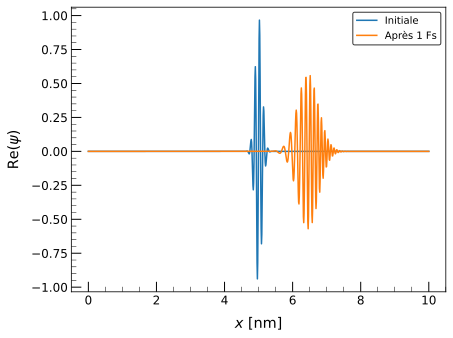

In [10]:
from scipy.fft import fft, ifft
from scipy import constants as cte


# Paramètres
L = 1e-8
N = 1000
k = np.arange(N)

# Grille spatiale
x = np.linspace(0, L, N)

# Pas spatial
dx = x[1] - x[0]

# Condition initiale
x0 = L / 2
sigma = 1e-10
kappa = 5e10
psi_x0 = np.exp(-((x - x0) ** 2) / (2 * sigma ** 2)) * np.exp(1j * kappa * x)

# Calcul des coefficients bk par DFT
bk = fft(psi_x0)

# Évolution temporelle
t = 1e-15  # Temps arbitraire pour l'illustration
E = np.pi**2 * cte.hbar**2 * k**2 / (2 * cte.m_e * L**2)
psi_xt = ifft(bk * np.exp(-1j * E * t / cte.hbar))

# Tracé de la partie réelle de la fonction d'onde
plt.plot(x * 1e9, psi_x0.real, label="Initiale")
plt.plot(x * 1e9, psi_xt.real, label=f"Après {t * 1e15:.0f} Fs")
plt.xlabel("$x$ [nm]")
plt.ylabel("Re($\\psi$)")
plt.legend()
plt.show()

I) *Expliquez pourquoi Newman s’en remet à la fonction rfft de numpy pour calculer la transformée en sinus.*

La fonction rfft de NumPy est utilisée pour effectuer une Transformée de Fourier Rapide (FFT) sur des données réelles. Newman recourt à rfft pour une raison spécifique liée à l'efficacité et à la spécificité du problème à résoudre. La fonction ``rfft`` est optimisée pour les données réelles et utilise moins de ressources computationnelles que la FFT complète, car elle n'a pas besoin de traiter la partie imaginaire symétrique des données, ce qui est le cas dans les signaux réels. Bien que l'équation de Schrödinger et certaines autres applications physiques nécessitent des calculs en termes de transformées de Fourier sinus et cosinus (pour les fonctions paires et impaires), il n'existe pas de fonction directe dans NumPy pour effectuer une transformée en sinus ou en cosinus seule. Newman utilise donc ``rfft`` et manipule les résultats pour obtenir une approximation ou un équivalent de la transformée en sinus, adaptant ainsi l'outil disponible à son besoin spécifique.

J) En injectant $\beta_k = \alpha_k + i\eta_k$ dans la solution et en prenant la partie réelle, nous obtenons

$$
Re\psi\left((x_n, t)\right) = \frac{1}{N} \sum_{k=1}^{N-1} \left[ \alpha_k \cos \left( \frac{\pi^2 \hbar k^2}{2ML^2} t \right) - \eta_k \sin \left( \frac{\pi^2 \hbar k^2}{2ML^2} t \right) \right] \sin \left( \frac{\pi kn}{N} \right)
$$

pour la partie réelle de la fonction d’onde. Une inspection vous convaincra qu’il s’agit de l’inverse d’une transformée en sinus pour la quantité entre crochets. Complétez votre programme pour qu’il calcule la partie réelle de $\psi(x_n, t)$ pour un $t$ arbitraire à l’aide de la fonction idst fournie par Newman. Testez votre programme en illustrant la fonction d’onde à $t$ = $10^{-16}$ s.



K) Maintenant que tout est en place, vous pouvez produire une animation de l’évolution de la fonction d’onde (normalisée) au cours du temps, en générant une image à plusieurs t (utilisez un incrément de 10−18 s). Il y a probablement plusieurs façons d’y arriver, l’une
d’elle étant le package visual. Prenez soin d’ajuster le taux de rafraîchissement et les échelles pour bien apprécier la dynamique de la fonction d’onde.

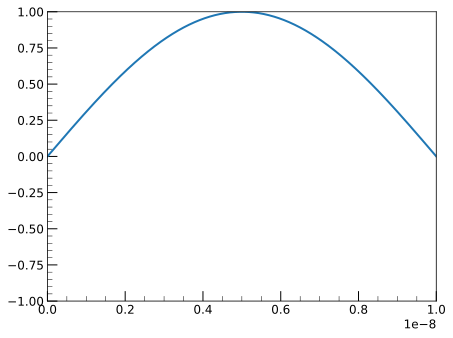

In [9]:
from matplotlib.animation import FuncAnimation

# Paramètres fictifs
L = 1e-8  # Longueur de la boîte en mètres
N = 1000  # Nombre de points de grille
x = np.linspace(0, L, N)  # Grille spatiale

# Fonction fictive pour calculer la partie réelle de psi(x, t)
# Remplacez ceci par votre propre fonction calculant psi(x, t) basée sur vos coefficients spectrale
def psi_xt(t, x):
    # Exemple basique avec une onde sinusoïdale variant dans le temps
    k = np.pi / L  # Nombre d'onde pour le premier mode
    omega = np.pi * 1e15  # Fréquence angulaire fictive
    return np.sin(k * x) * np.cos(omega * t)

# Initialisation du plot
fig, ax = plt.subplots()
line, = ax.plot(x, psi_xt(0, x), lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1, 1)

def init():
    line.set_data(x, psi_xt(0, x))
    return line,

def update(frame):
    y = psi_xt(frame, x)  # Mettre à jour psi(x, t) à chaque frame
    line.set_data(x, y)
    return line,

# Créer l'animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1e-15, 100), init_func=init, blit=True)

plt.show()

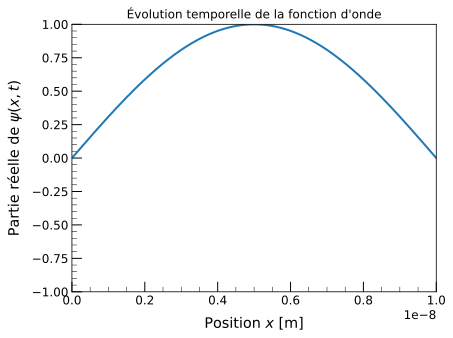

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Paramètres
L = 1e-8  # Longueur de la boîte en mètres
N = 1000  # Nombre de points de grille
x = np.linspace(0, L, N)  # Grille spatiale

# Fonction pour calculer la partie réelle de psi(x, t)
def psi_xt(t, x):
    k = np.pi / L  # Nombre d'onde pour le premier mode sinusoïdal
    omega = 2 * np.pi * 1e14  # Ajustez la fréquence pour visualiser le mouvement
    return np.sin(k * x) * np.cos(omega * t)

# Initialisation du plot
fig, ax = plt.subplots()
line, = ax.plot(x, psi_xt(0, x), lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1, 1)
ax.set_xlabel("Position $x$ [m]")
ax.set_ylabel("Partie réelle de $\\psi(x, t)$")
ax.set_title("Évolution temporelle de la fonction d'onde")

def init():
    line.set_data(x, psi_xt(0, x))
    return line,

def update(frame):
    y = psi_xt(frame, x)
    line.set_data(x, y)
    return line,

# Créer l'animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1e-15, 500), init_func=init, blit=True)

plt.show()


I) Laissez tourner votre animation un moment et décrivez ce que vous observez, en utilisant bien entendu un langage se rapportant à la physique du problème.*